# Peakbagging with Dynesty

In [1]:
from preamble import *
from preamble.dynesty.pooled_lw import *

/home/joel/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from os.path import isfile
@jax.jit
def ln_like(θ):
#     return sum(ln_like_chi2_2dof(m, o) for m, o in zip(model(θ), chunk_PS))
    return ln_like_chi2_2dof(chunk_model(ν, θ), PS)
reset = False

if (not isfile(checkpoint)) or reset:
    sampler = dynesty.DynamicNestedSampler(ln_like, prior_transform, Ndims, reflective=[0])
    sampler.run_nested()
    summary = summarise(sampler)
    np.save(checkpoint, {'summary': summary})
else:
    d = np.load(checkpoint, allow_pickle=True)[()]
    summary = d['summary']
    
from os import makedirs
from os.path import basename
figdir = f"figures/{basename(checkpoint).replace('.npy', '')}"
makedirs(figdir, exist_ok=True)

In [3]:
if "pooled_lw_rot" in checkpoint:
    δν_rot_samples = (lambda s: s[:,-1] - s[:,-2])(summary['new_samples'][:, :N_shared])
    plt.hist(δν_rot_samples, bins=128, density=True)
    plt.axvline(0, ls='dashed', c='C1')
    print(np.sum(np.where(δν_rot_samples > 0))/np.sum(np.where(δν_rot_samples < 10)))
    
    plt.gcf().set_size_inches(4,3)
    plt.xlabel(r"$(\delta\nu_{\text{rot}, 2} - \delta\nu_{\text{rot}, 1})/\mu$Hz")
    plt.ylabel(r"Posterior PDF")
    plt.show()

In [4]:
from corner import corner
from scipy.stats import norm

for i in range(len(nu_guess)):
    l = ll_guess[i]
    corner(summary['new_samples'][:, get_indices(i)], bins=30,
#            truths=[nu_guess[i], None, δν_guess[i - N_radial] if l > 0 else None][:2 if l == 0 else 3],
#            truth_color=f"C{l}",
           show_titles=True, quantiles=[norm.cdf(z) for z in (-1, 1)],
           labels=[quantity_labels[k] for k in slices]
          )
    plt.savefig(f'{figdir}/mode_{i}.png', bbox_inches='tight', dpi=300, transparent=True)
    plt.close('all')

In [5]:
for k in slices:
    s = slices[k]
    try:
        corner(
            summary['new_samples'][:, s],
            truths={'ν': nu_guess, 'A': None, 'δν': δν_guess[N_radial:]}[k],
    #         truth_color=[f"C{l}" for l in ll_guess if (l > 0 or i < 2)],
            truth_color='black',
            labels=[mode_labels[k].format(_) for _, l in enumerate(ll_guess) if (l>0 or k != 'δν')]
        )
        plt.savefig(f"{figdir}/{k}.png", bbox_inches='tight', dpi=300, transparent=True)
        plt.close('all')
    except (ValueError, IndexError):
        plt.close('all')
        pass

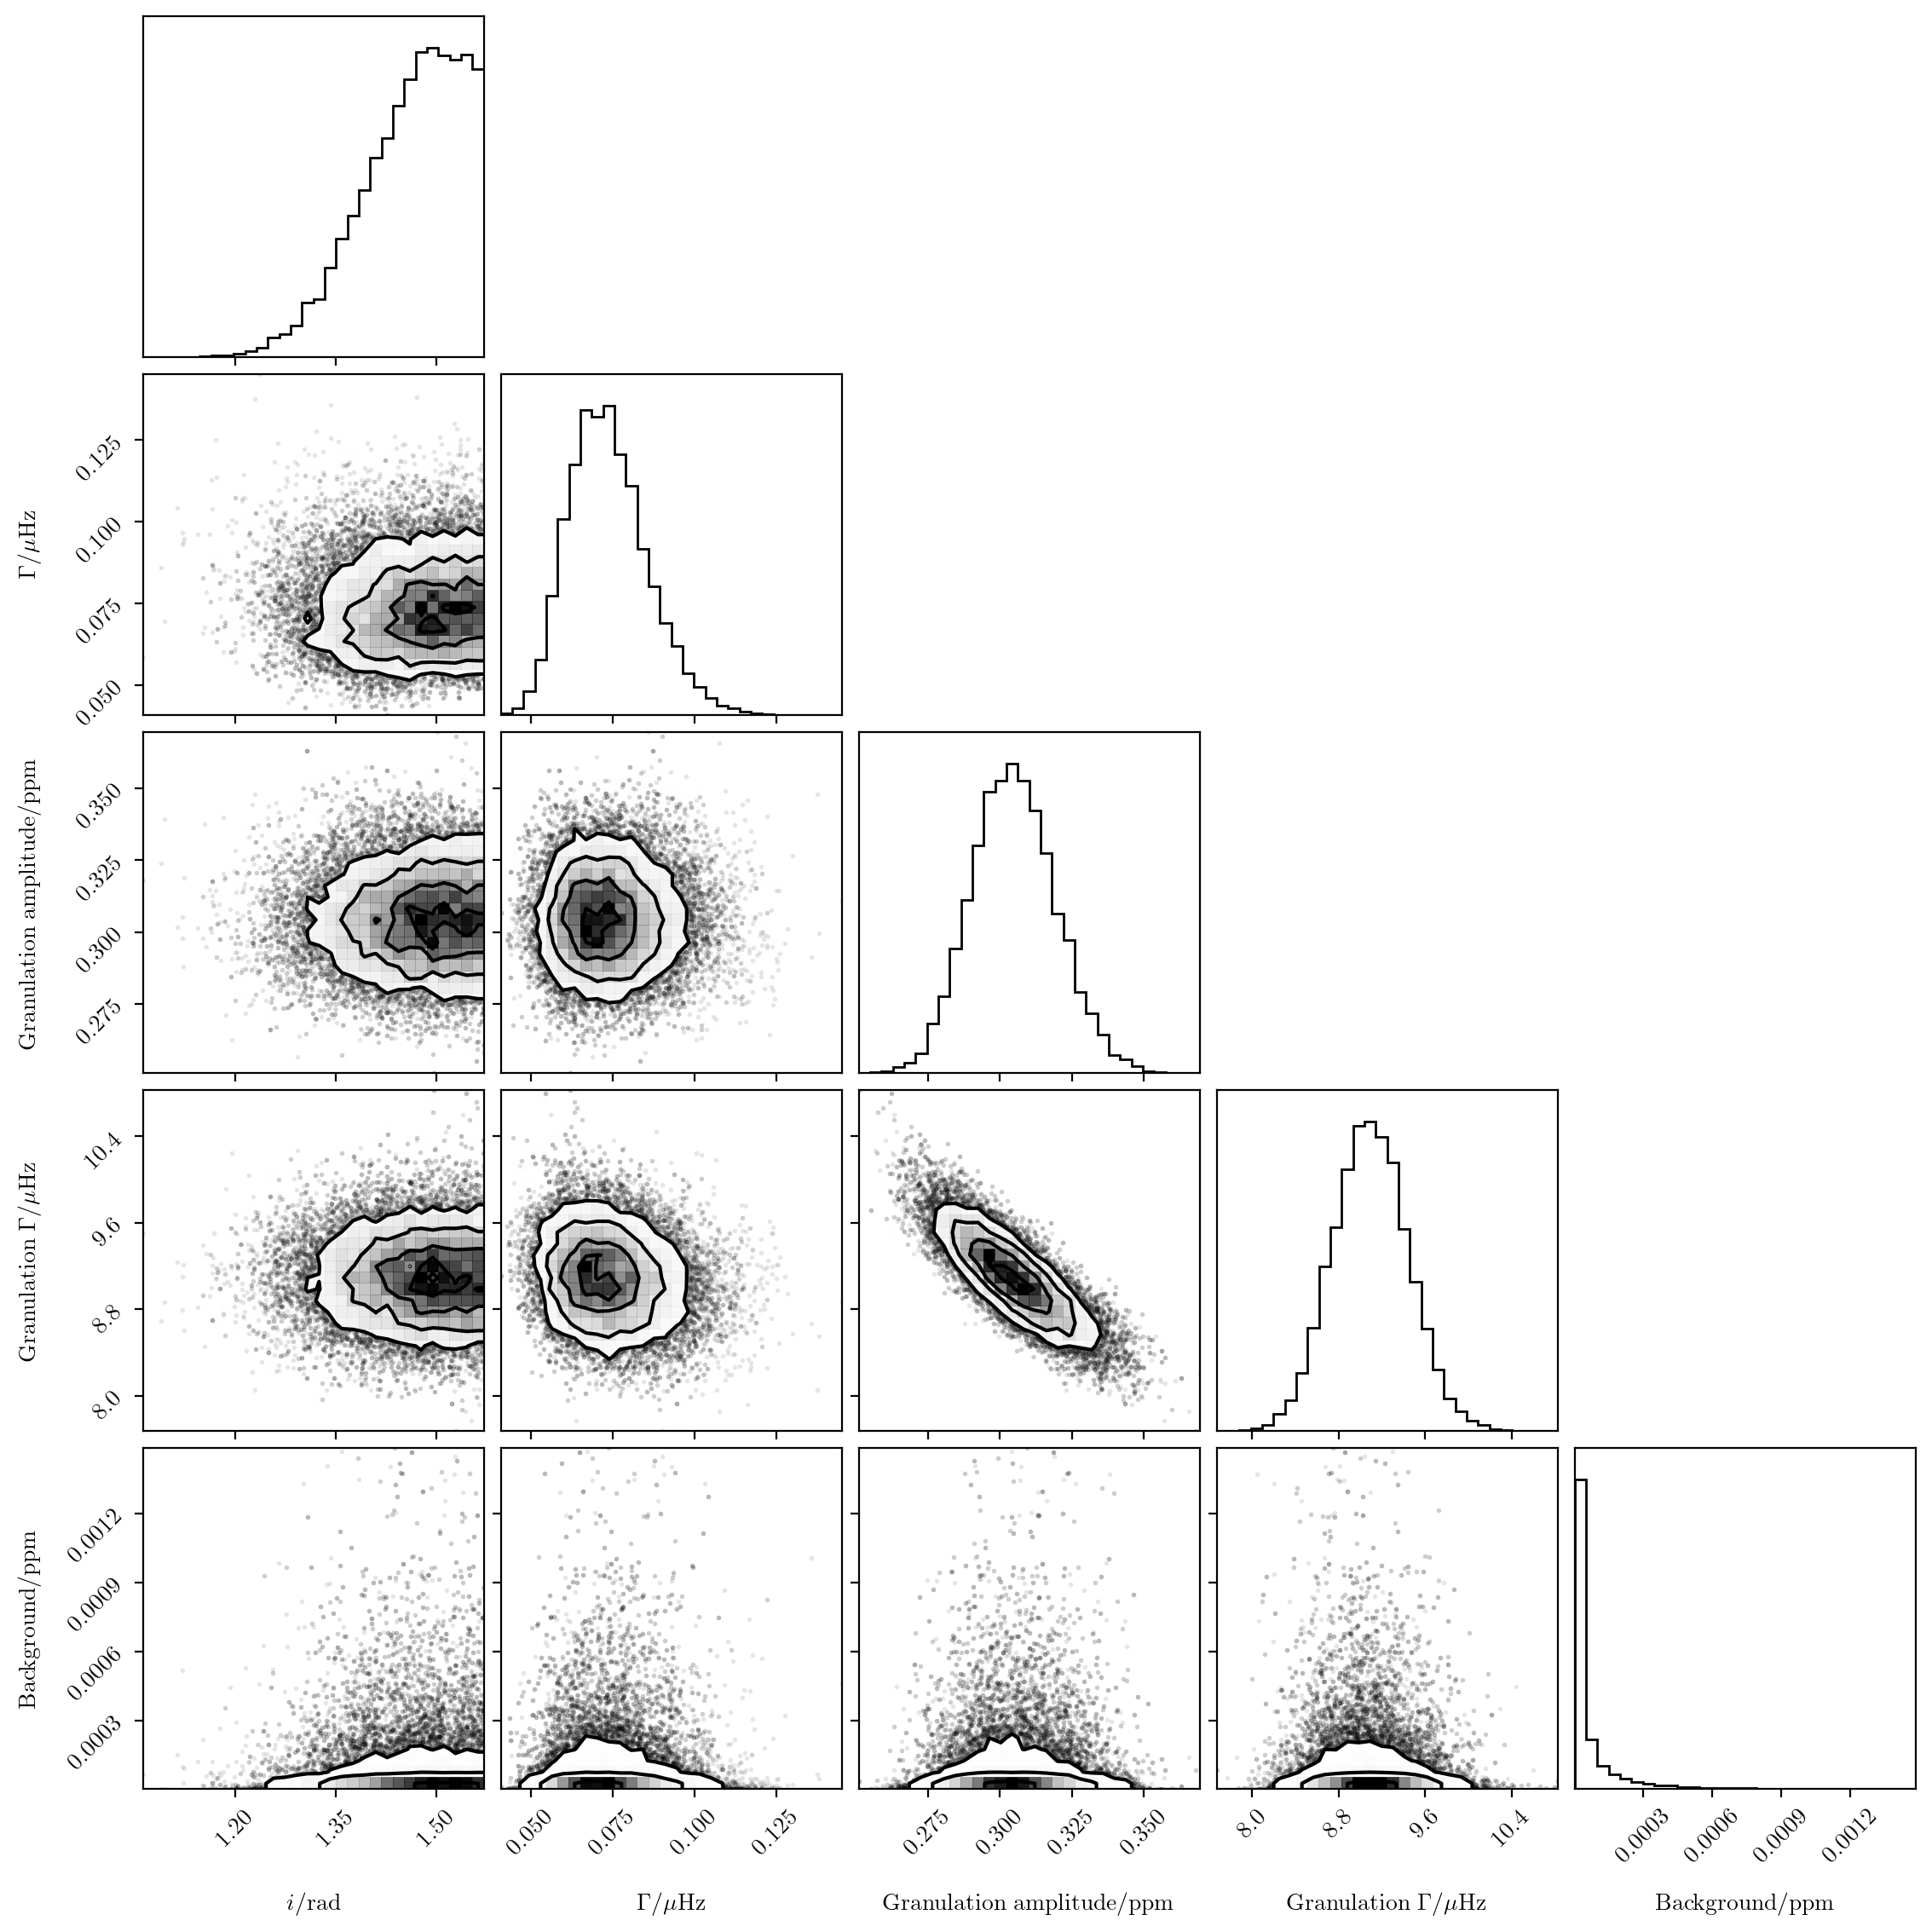

In [6]:
corner(
    summary['new_samples'][:, :N_shared], bins=30,
    labels=[shared_labels[k] for k in shared_quantities]
)
plt.savefig(f"{figdir}/shared.png", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

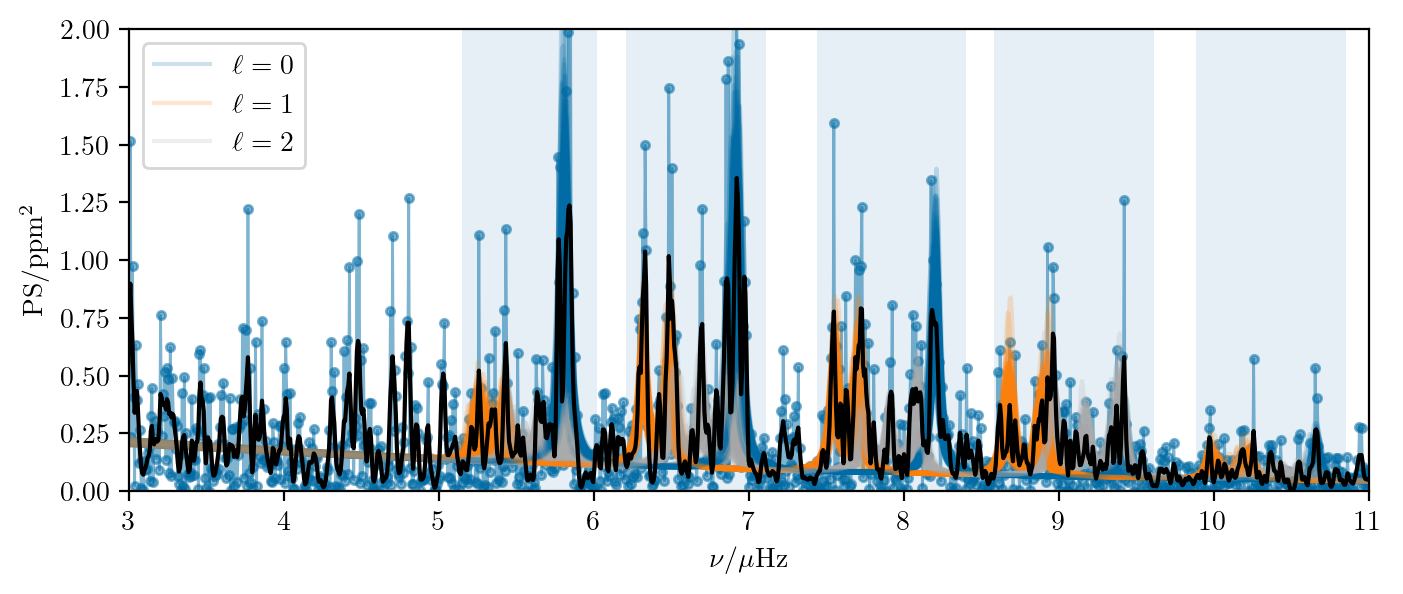

In [7]:
m = slice(None, None)
plt.plot(ν, PS, '.-', lw=1, alpha=.5)
# plt.plot(ν[1:-1], (PS[1:-1] + PS[2:] + PS[:-2])/3, c='black', zorder=1000)
plt.plot(ν, gaussian_filter1d(PS, 1), c='black', zorder=1000)
for _ in range(-300, 0):
    for l in (0, 1, 2):
        plt.plot(ν, chunk_model(ν, summary['new_samples'][m][_], only_l=l),
                 c=f'C{l}', alpha=.2, label=f"$\\ell = {l}$" if _ == -1 else None)
for b in bounds:
    plt.axvspan(*b, edgecolor='none', alpha=.1)
plt.xlim(3, 11)
plt.ylim(0, 2)
plt.legend()
plt.gcf().set_size_inches(8, 3)

plt.xlabel(r"$\nu/\mu$Hz")
plt.ylabel("PS/ppm$^2$")
plt.savefig(f"{figdir}/samples.png", dpi=300, bbox_inches='tight')

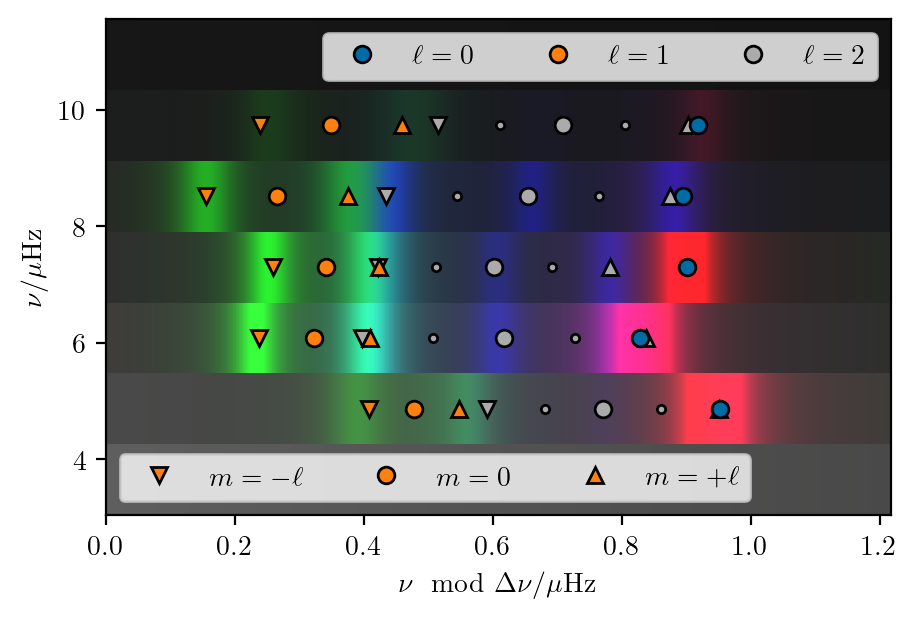

In [8]:
m = slice(None, None)
channels = [None,None,None]
for l in (0, 1, 2):
    out = [echelle_power(ν, chunk_model(ν, summary['new_samples'][m][_], only_l=l), Δν) for _ in range(-300, 0)]
    channels[l] = np.mean([o[-1] for o in out], axis=0)
    
νmodΔν, ν0, mesh, _ = out[0]
plt.imshow(
    gaussian_filter(np.array(channels).transpose(1,2,0), (0, 0, 0)) * 2,
    extent=(0, Δν, np.min(ν0)-Δν/2, np.max(ν0)+Δν/2), aspect='auto', origin='lower', interpolation='none'
)

legend = {}
handles = []
for l, ν0, δν in zip(ll_guess, nu_guess, δν_guess):
    for m in range(-l, l+1):
        νi = ν0 + δν * m
        a = plt.plot(νi % Δν, (νi // Δν) * Δν, {l: '^', -l: 'v', 0: 'o'}.get(m, '.'),
                     markerfacecolor=f"C{l}",markeredgecolor='black',
                     zorder=4-l, label=f'$\ell={l}$' if (l not in legend) and m == 0 else None)
        if l == 1:
            handles.append(a[0])
        if m == 0:
            legend[l] = None
firstlegend = plt.legend(loc='upper right', ncol=3)
plt.legend(handles, [f"$m = {_}$" for _ in (r'-\ell', '0', r'+\ell')],
           loc='lower left', ncol=3)
plt.gca().add_artist(firstlegend)
plt.gcf().set_size_inches(4.5,3)
plt.tight_layout()
plt.xlabel(r"$\nu\mod\Delta\nu/\mu$Hz")
plt.ylabel(r"$\nu/\mu$Hz")
plt.savefig(f"{figdir}/model.png", dpi=300, bbox_inches='tight')